# Data enrichment: add land-use pattern to accident records

Input: data/data_s2.csv

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import os
from pathlib import Path
import json
import geo_functions as gf
import data_retrieve_functions as drf
import visualisation_functions as vf
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from tqdm import tqdm

def eval_k_means(estimator, data, n_clusters):

    estimator.fit(data)
    print('Clusters %s - Silhouette_score %s' % (n_clusters,
                                                 metrics.silhouette_score(data,
                                                                          estimator.labels_)))
    return estimator.labels_

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data_path = os.path.join(Path(os.getcwd()).parent.parent, 'data/')
with open(os.path.join(data_path, 'value_mapping.txt'), encoding='utf-8') as json_file:
    value_dict = json.load(json_file)
df = pd.read_csv(os.path.join(data_path, "data_s2.csv"))
df.iloc[0:3].transpose()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2
id,1,1,2
type,11,11,11
weather,1,1,1
reason,1094,1094,1043
lat,22.5931,22.5931,22.7825
long,114.016,114.016,113.839
road_type,21,21,11
gender,1,0,1
age,"(45, 50]","(45, 50]","(60, 65]"
edu,Unknown,Unknown,2


## 1 Find the zone of the accidents
This part focuses on those records with geolocation info: lat, long.

In [4]:
# Load grids
gdf_grid = gpd.GeoDataFrame.from_file(os.path.join(data_path, 'geo/grids.shp'))

# Drop duplicated records due to multiple involved persons
df_nd = df.drop_duplicates(subset=["id"])

# Convert the records with geolocation into GeoDataFrame and find which zone they fall into
gdf_acc = gf.df2gdf_point(df_nd.loc[~df_nd.lat.isna(), :], 'long', 'lat')
gdf_acc.loc[:, 'zone'] = gf.point2zone(gdf_grid, gdf_acc, var2return="zone")

C:\Users\yuanlia\AppData\Roaming\Python\Python37\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
D:\sz_accidents\src\lib\geo_functions.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  gdf_zone = gpd.sjoin(gdf, gdf_zone.loc[:, [var2return, "geometry"]], how="left")


### 1.1 Count the number of accidents in each zone and save it

In [5]:
## Count the number of accidents in each zone
gdf_acc_stats = gdf_acc.groupby('zone')[['id']].count().reset_index().rename(columns={'id': 'acc_num'})
gdf_acc_stats.loc[:, 'zone'] = gdf_acc_stats.loc[:, 'zone'].astype(int)

## Save the visited zones into a new shapefile
gdf_grid_visit = gdf_grid.loc[gdf_grid['zone'].isin(gdf_acc.loc[:, 'zone'].unique()), :]
gdf_grid_visit = pd.merge(gdf_grid_visit, gdf_acc_stats, on='zone').loc[:, ['zone', 'acc_num', 'geometry']]

## Get centroid of each polygon
gdf_grid_visit.loc[:, 'X'] = gdf_grid_visit.geometry.apply(lambda x: x.centroid.x)
gdf_grid_visit.loc[:, 'Y'] = gdf_grid_visit.geometry.apply(lambda x: x.centroid.y)
gdf_grid_visit.to_file(os.path.join(data_path, 'geo/grids_acc.shp'))
gdf_grid_visit.head()

,zone,acc_num,geometry,X,Y
0,1008,1,"POLYGON ((113.76819 22.72548, 113.76954 22.727...",113.770997,22.725541
1,1093,3,"POLYGON ((113.77214 22.73684, 113.77349 22.739...",113.774943,22.736900
2,1249,261,"POLYGON ((113.78161 22.69192, 113.78296 22.694...",113.784418,22.691972
3,1254,1,"POLYGON ((113.78108 22.71446, 113.78244 22.716...",113.783891,22.714521
4,1255,1,"POLYGON ((113.78098 22.71897, 113.78233 22.721...",113.783786,22.719031


### 1.2 Join zone to the data of accident records

In [6]:
# Drop a few accidents' location outside the study area
gdf_acc = gdf_acc.loc[~gdf_acc.loc[:, 'zone'].isnull(), :]

# Merge df_nd back to the records with zone info
df_acc = pd.DataFrame(gdf_acc.drop(columns="geometry"))
df_nd = pd.concat([df_nd.loc[df_nd.lat.isna(), :], df_acc])

# Merge zone info back to the complete accident records
df = pd.merge(df, df_nd.loc[:, ["id", "zone"]], left_on="id", right_on="id", how="left")

# Fill unknown zones
df.zone.fillna("Unknown", inplace=True)
df.zone = df.zone.apply(lambda x: str(int(x)) if x != "Unknown" else x)

## 2 Retrieve POI data from Baidu API
### 2.1 Prepare query data

In [ ]:
df_query = drf.poi_req_prep(gdf_grid_visit, data_path)
df_query.head()

### 2.2 Send queries to Baidu Place API
This takes a few hours to download.

In [ ]:
target_file = "zone_visit_poi_output.csv"
df_q = pd.read_csv(os.path.join(data_path, "zone_visit_poi.csv"))
df_q_results = pd.read_csv(os.path.join(data_path, target_file))

## Load all the done queries in case the api access is interrupted where a resume is needed
list_df = [(x,y) for x,y in df_q_results.loc[:, ["zone", "POI"]].values]
tqdm.pandas(desc="POI searching")
df_q.progress_apply(lambda row: drf.zone_poi_search(row, data_path, list_df, target_file), axis=1)

## 3 Process POIs to enrich crash dataset
### 3.1 Preprocess obtained POIs number by zone x POI_type

In [7]:
target_file = "zone_visit_poi_output.csv"
## Load POI_type_dict
POI_type_dict = value_dict['POI_type']
POI_type_dict_reverse = {v: k for k,v in POI_type_dict.items()}
## Load POI data from API results and convert it into zone, poi_1,...,poi_19 format
df_poi = pd.read_csv(os.path.join(data_path, target_file))
df_poi_list = []
for zone, frame in df_poi.groupby('zone'):
    fr = pd.DataFrame(frame.loc[:, ['POI_num']].transpose().values,
                      columns=["POI_" + POI_type_dict_reverse[x] for x in frame.loc[:, 'POI'].transpose().values])
    fr.loc[:, 'zone'] = int(zone)
    df_poi_list.append(fr)
df_poi = pd.concat(df_poi_list)
df_poi = df_poi.astype(int)

### 3.2 Land use cluster to merge 1000+ zones into smaller groups by their land use patterns revealed by POIs

#### 3.2.1 Process POI matrix

In [10]:
poi_list = ['food', 'hotel', 'shopping', 'life', 'beauty', 'tourism', 'leisure',
       'sports', 'education', 'media', 'medical', 'auto', 'finance',
       'real_estate', 'company', 'gov_org', 'access', 'nature', 'transport']

X = df_poi
X = X.fillna(0)
X = X.loc[(X.T != 0).any(), :]
zones = X["zone"].astype(int).values
X = X.drop(columns=["zone"]).values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#### 3.2.2 PCA

In [11]:
pca = PCA(n_components = 0.95)
pca.fit(X)
X_reduced = pca.transform(X)

#### 3.2.3 K-means to find the optimal number of clusters

In [12]:
for n_clusters in range(2,21):
    labels = eval_k_means(KMeans(n_clusters=n_clusters, random_state=0),
                  data=X_reduced,
                  n_clusters=n_clusters)

Clusters 2 - Silhouette_score 0.4622392066278885
Clusters 3 - Silhouette_score 0.36112674138492407
Clusters 4 - Silhouette_score 0.36084135836085596
Clusters 5 - Silhouette_score 0.3269960304398354
Clusters 6 - Silhouette_score 0.33421786667249254
Clusters 7 - Silhouette_score 0.32544641605009805
Clusters 8 - Silhouette_score 0.318009524959651
Clusters 9 - Silhouette_score 0.30442091080617156
Clusters 10 - Silhouette_score 0.31304059593667155
Clusters 11 - Silhouette_score 0.3189800740510416
Clusters 12 - Silhouette_score 0.3212012405847694
Clusters 13 - Silhouette_score 0.30733317180824554
Clusters 14 - Silhouette_score 0.2810845724627062
Clusters 15 - Silhouette_score 0.28176675418800695
Clusters 16 - Silhouette_score 0.27053506004439243
Clusters 17 - Silhouette_score 0.2601279756034738
Clusters 18 - Silhouette_score 0.24778340234488136
Clusters 19 - Silhouette_score 0.2487874746395073
Clusters 20 - Silhouette_score 0.25825450556542273


#### 3.2.4 Show the results of selected number of clusters
K = 6 according to the Silhouette score where it appears as the first local maximum value.

In [13]:
n_clusters = 6
labels = eval_k_means(KMeans(n_clusters=n_clusters, random_state=0),
              data=X_reduced,
              n_clusters=n_clusters)
df_zone = pd.DataFrame([(x, y) for x,y in zip(zones, labels)], columns=["zone", "cluster"])
df_zone.loc[:, 'cluster'] = df_zone.loc[:, 'cluster'] + 1
df_zone.zone = df_zone.zone.astype(str)
df_zone.to_csv(os.path.join(data_path, 'zone_poi_cluster.csv'), index=False)

Clusters 6 - Silhouette_score 0.33421786667249254


#### 3.2.5 Visualise the results of cluster

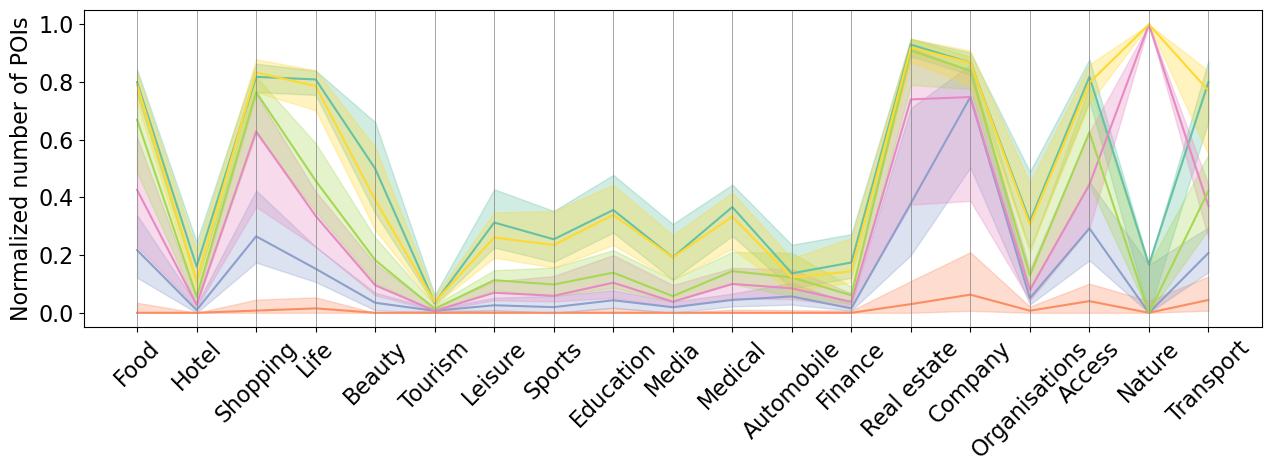

In [29]:
# Visualise the clusters that have distinct land use pattern
figure_path = os.path.join(Path(os.getcwd()).parent.parent, 'figures/')
vf.parallel_coordinates(X,
                        df_zone.loc[:, 'cluster'].values,
                        fig_folder=figure_path,
                        fig_name="clusters_parallel.png",
                        save=True)

### 3.3 Add cluster info back to the complete accident dataset
Remove some columns.

In [16]:
df = pd.merge(df, df_zone.loc[:, ['zone', 'cluster']], left_on='zone', right_on='zone', how='left')
df.cluster.fillna('Unknown', inplace=True)
df.cluster = df.cluster.apply(lambda x: str(int(x)) if x != 'Unknown' else x)
df.drop(columns=['lat', 'long', 'zone'], inplace=True)
df.iloc[0:3].transpose()

,0,1,2
id,1,1,2
type,11,11,11
weather,1,1,1
reason,1094,1094,1043
road_type,21,21,11
gender,1,0,1
age,"(45, 50]","(45, 50]","(60, 65]"
edu,Unknown,Unknown,2
respon,0,1,0
veh_type,2,2,4


In [17]:
df.to_csv(os.path.join(data_path, 'data_s3.csv'), index=False)